# Autoregressive Models

An autoregressive (AR) model is when a value from a time series is regressed on previous values (called lags) from that same time series.  

The order of the AR is the number of previous values in the series that are used for prediction.  For example an AR(1) uses the first preceeding value in a time series.

AR(1) formula = yt=β0+β1yt−1+ϵt

AR(2) formula = yt=β0+β1yt−1+β2yt−2+ϵt

AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets.  Mean reversion is the theory suggesting that values and/or returns eventually move back toward the mean or average of a time series. 

An AR model is could be appropriate if consecutive values appear to follow one another fairly closely (which is typical in financial data).  In order for the model to work correctly, stationarity is assumed.

## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

The coefficient of correlation between two values in a time series is called the autocorrelation function.  The ACF is a way to measure the linear relationship between an observation at time t and the observations at previous times. 

The PACF is most useful for identifying the order of an autoregressive model. Specifically, sample partial autocorrelations that are significantly different from 0 indicate lagged terms of y that are useful predictors of yt.

## Code Samples

### Setup

In [55]:
# setup
from helpers.time_series import tsplot
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pandas.tools.plotting import lag_plot


%matplotlib inline

np.random.seed(42)

### Create Simulated Data

(<matplotlib.axes._subplots.AxesSubplot at 0x11e568208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11dfa3940>)

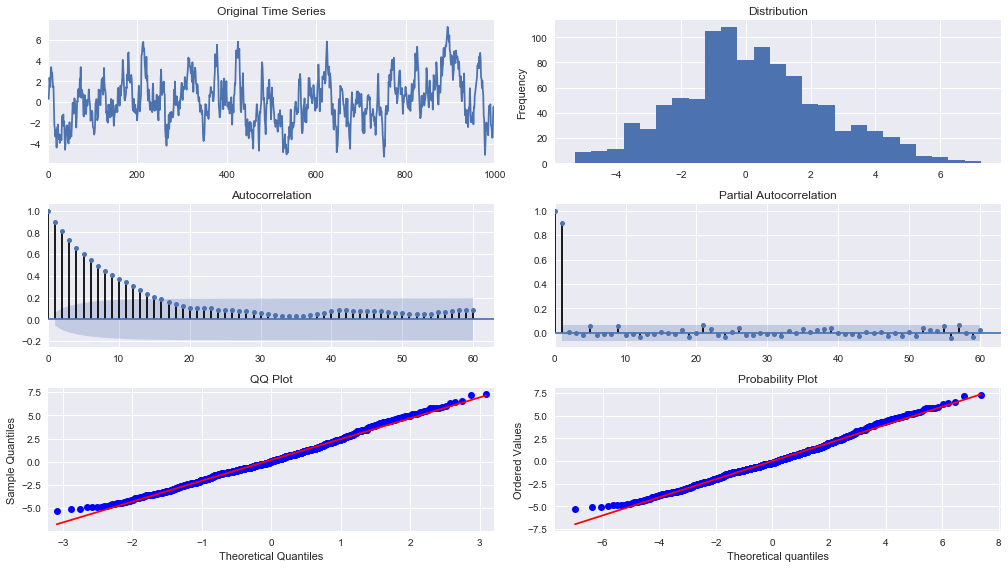

In [56]:
#simulated data
alpha = 0.9
ar1 = np.array([1, -alpha])
ma1 = np.array([1])

simulated_data_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

#plot the data
tsplot(simulated_data_1)


### Plot lags

The PACF chart can show you which order to start with for AR modeling but a scatter plot can be used to compare the lags compare to each other.  The closer to a line the more correlated they are.

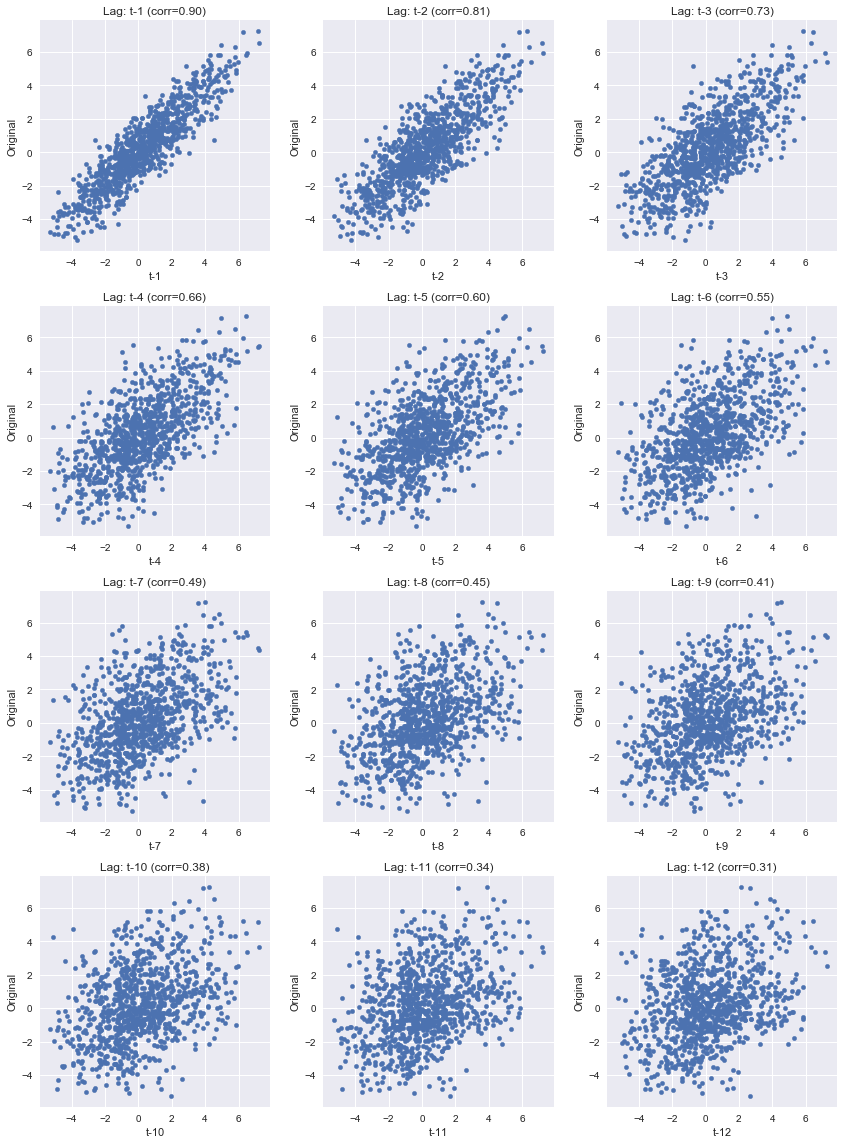

In [62]:
lags=12

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([pd.Series(simulated_data_1), pd.Series(simulated_data_1).shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();


### Discover the best lag to use based on 'aic'

You can also select an order by using information criteria ('aic', 'bic').

In [63]:
est_order = smt.AR(simulated_data_1).select_order(
    maxlag=30, ic='aic', trend='nc')

'best lag order = {}'.format(est_order)


'best lag order = 1'

### Estimating a model

In [64]:
mod = ARMA(simulated_data_1, order=(1, 0))
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1398.152
Method:                       css-mle   S.D. of innovations              0.979
Date:                Thu, 05 Apr 2018   AIC                           2802.303
Time:                        15:41:25   BIC                           2817.027
Sample:                             0   HQIC                          2807.899
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1943      0.303      0.641      0.522      -0.400       0.788
ar.L1.y        0.8988      0.014     65.390      0.000       0.872       0.926
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1126           +0.0000j            1.1126            0.0000
-----------------------------------------------------------------------------
"""

### Forecasting Using AR Model

#### Using built in predict method

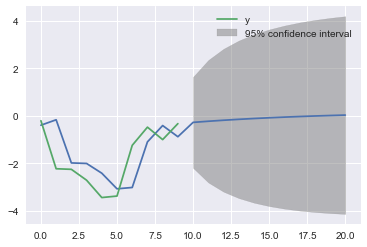

In [65]:
mod = ARMA(simulated_data_1, order=(1, 0))
res = mod.fit()

res.plot_predict(start=990, end=1010)
plt.show()

#### Using Test and Train data

Lag: 1
Coefficients: [ 0.18916651  0.89910196]
predicted=-1.834458, expected=-2.707630
predicted=-2.245269, expected=-3.438487
predicted=-2.902384, expected=-3.375739
predicted=-2.845967, expected=-1.240478
predicted=-0.926150, expected=-0.475588
predicted=-0.238435, expected=-0.999208
predicted=-0.709223, expected=-0.326704
Test MSE: 0.845


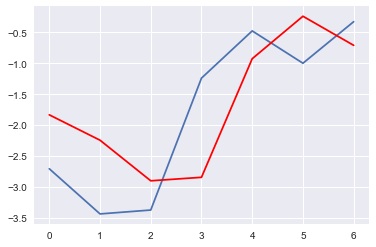

In [66]:
train, test = simulated_data_1[1:len(simulated_data_1)-7], simulated_data_1[len(simulated_data_1)-7:]
model = ARMA(train, order=(1, 0))
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
